In [42]:
#######################################################################################
#################################### LIBRARIES ########################################
#######################################################################################

import math
import random
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import pandas as pd
from datetime import datetime
import joblib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [43]:
# Loading of Metereological daily data (2023, Milan)
meteo_df_jan_23 = pd.read_csv("Meteo Database csv 2023\Milano-2023-Gennaio.csv", sep=";")
meteo_df_feb_23 = pd.read_csv("Meteo Database csv 2023\Milano-2023-Febbraio.csv", sep=";")
meteo_df_mar_23 = pd.read_csv("Meteo Database csv 2023\Milano-2023-Marzo.csv", sep=";")

meteo_df_apr_23 = pd.read_csv("Meteo Database csv 2023\Milano-2023-Aprile.csv", sep=";")
meteo_df_may_23 = pd.read_csv("Meteo Database csv 2023\Milano-2023-Maggio.csv", sep=";")
meteo_df_jun_23 = pd.read_csv("Meteo Database csv 2023\Milano-2023-Giugno.csv", sep=";")

meteo_df_jul_23 = pd.read_csv("Meteo Database csv 2023\Milano-2023-Luglio.csv", sep=";")
meteo_df_aug_23 = pd.read_csv("Meteo Database csv 2023/Milano-2023-Agosto.csv", sep=";")
meteo_df_sep_23 = pd.read_csv("Meteo Database csv 2023\Milano-2023-Settembre.csv", sep=";")

meteo_df_oct_23 = pd.read_csv("Meteo Database csv 2023\Milano-2023-Ottobre.csv", sep=";")
meteo_df_nov_23 = pd.read_csv("Meteo Database csv 2023\Milano-2023-Novembre.csv", sep=";")
meteo_df_dec_23 = pd.read_csv("Meteo Database csv 2023\Milano-2023-Dicembre.csv", sep=";")

# dataframe concat
meteo_df_23=pd.concat([
    meteo_df_jan_23, 
    meteo_df_feb_23, 
    meteo_df_mar_23, 
    meteo_df_apr_23,
    meteo_df_may_23, 
    meteo_df_jun_23, 
    meteo_df_jul_23, 
    meteo_df_aug_23, 
    meteo_df_sep_23,
    meteo_df_oct_23, 
    meteo_df_nov_23, 
    meteo_df_dec_23
    ])

#data column rename
meteo_df_23.rename(columns={"DATA": "Data"}, inplace=True)

#data set to index
meteo_df_23.set_index(pd.to_datetime(meteo_df_23["Data"], dayfirst=True), inplace=True)

#Dropped data column
meteo_df_23.drop(["Data"], inplace=True,  axis=1)


#week-day based score added
week_days=[0, 0, 0, 0, 0, 1, 1]
week_year=[]
j=0
for i in range(len(meteo_df_23)):
    week_year.append(week_days[j])
    j=j+1
    if j==7:
        j=0

#day meteo phenomena conversion to score
stats=[]
for i in range(len(meteo_df_23)):
    if meteo_df_23["FENOMENI"].iloc[i] not in stats:
        stats.append(meteo_df_23["FENOMENI"].iloc[i])

weather_keys={
    "nan":0,
    'nebbia ':1,
    'pioggia ':2,
    'pioggia nebbia ': 3,
    'pioggia temporale ':4,
    'pioggia temporale nebbia ':5, 
    'pioggia neve ':6
}

#NaN values set to sunny
meteo_df_23["FENOMENI"]=meteo_df_23["FENOMENI"].fillna(0)

for i in meteo_df_23.index:
    if meteo_df_23.loc[i, "FENOMENI"]!=0:
        meteo_df_23.loc[i, "FENOMENI"]=weather_keys[meteo_df_23.loc[i, "FENOMENI"]]


display(meteo_df_23)

,LOCALITA,TMEDIA °C,TMIN °C,TMAX °C,PUNTORUGIADA °C,UMIDITA %,VISIBILITA km,VENTOMEDIA km/h,VENTOMAX km/h,RAFFICA km/h,PRESSIONESLM mb,PRESSIONEMEDIA mb,PIOGGIA mm,FENOMENI
Data,,,,,,,,,,,,,,
2023-01-01,Milano,8.0,8.0,9.0,8.0,100.0,2.0,6.0,9.0,0.0,1031.0,0.0,0.0,3
2023-01-02,Milano,9.0,8.0,10.0,9.0,100.0,3.0,3.0,5.0,0.0,1030.0,0.0,0.0,2
2023-01-03,Milano,10.0,9.0,10.0,10.0,100.0,7.0,3.0,8.0,0.0,1029.0,0.0,0.0,2
2023-01-04,Milano,10.0,6.0,11.0,9.0,95.0,13.0,5.0,11.0,0.0,1029.0,0.0,0.0,1
2023-01-05,Milano,9.0,5.0,14.0,7.0,91.0,12.0,8.0,21.0,0.0,1023.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,Milano,9.0,7.0,11.0,6.0,86.0,15.0,3.0,8.0,0.0,1025.0,0.0,0.0,0
2023-12-28,Milano,9.0,8.0,10.0,7.0,88.0,16.0,4.0,9.0,0.0,1026.0,0.0,0.0,2
2023-12-29,Milano,9.0,8.0,10.0,6.0,82.0,20.0,6.0,9.0,0.0,1022.0,0.0,0.0,2


In [44]:
# Latitude (decimal degrees):	45.465
# Longitude (decimal degrees):	9.188
# Elevation (m):	128
# Radiation database:	PVGIS-SARAH3


# Slope: 40 deg. (optimum)
# Azimuth: 3 deg. (optimum)
# Nominal power of the PV system (c-Si) (kWp):	1000.0
# System losses (%):	0.4

power_production=pd.read_csv("Power 2023.csv")
power_production=power_production.dropna()
for index in power_production.index:
    power_production.loc[index, "time"] = power_production.loc[index, "time"][0:4] + '/'  \
        + power_production.loc[index, "time"][4:6]+ '/' \
            +power_production.loc[index, "time"][6:8] + '/'+ power_production.loc[index, "time"][9:11]+':'+ power_production.loc[index, "time"][11:]




new_columns=[[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
for index in power_production.index:
    new_columns[int(power_production.loc[index, "time"][11:13])%24].append(float(power_production.loc[index, "P"]))



power_df=pd.DataFrame()
for i in range(len(new_columns)):
    power_df[f"P_{i}"]=new_columns[i]

power_df.set_index(meteo_df_23.index, inplace=True)
display(power_df)



,P_0,P_1,P_2,P_3,P_4,P_5,P_6,P_7,P_8,P_9,...,P_14,P_15,P_16,P_17,P_18,P_19,P_20,P_21,P_22,P_23
Data,,,,,,,,,,,,,,,,,,,,,
2023-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,139100.0,81950.0,...,13200.0,14350.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27940.0,48970.0,...,68220.0,13420.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37940.0,40400.0,...,61670.0,8260.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,158600.0,270410.0,...,75360.0,76990.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,77000.0,266350.0,...,496560.0,197260.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56870.0,91300.0,...,64910.0,6350.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-12-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14900.0,10500.0,...,37780.0,2730.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-12-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15760.0,25880.0,...,19130.0,300.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
# Selezioniamo solo le caratteristiche pertinenti
# Utilizzeremo: temperatura, umidità, velocità del vento, ecc., come variabili indipendenti
# Prezzo come variabile dipendente
X = meteo_df_23[['TMIN °C', 'TMAX °C', 'TMEDIA °C', 'UMIDITA %',
       'VISIBILITA km', 'PRESSIONESLM mb', 'PRESSIONEMEDIA mb', 'PIOGGIA mm', "FENOMENI",
       #"Prices_y"
       ]]  # Aggiungi altre colonne meteo se necessario
y = power_df

# Creazione dei set di addestramento e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)



In [46]:
# param_grid = {
#     'n_estimators': [25,50,75,100, 200, 300],
#     'max_depth': [1,2, 3,4, 5,6, 7,8],
#     'learning_rate': [0.001,0.005, 0.01, 0.1, 0.2],
#     'min_samples_split': [2, 5, 10, 20],
#     'min_samples_leaf': [1, 2, 5, 10]
# }

# grid_search = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid, cv=3, scoring='neg_mean_absolute_error')
# grid_search.fit(X_train, y_train)

# print(f"Best parameters: {grid_search.best_params_}")
# print(f"Best score: {grid_search.best_score_}")

In [47]:
# Creazione del modello di regressione lineare
model = GradientBoostingRegressor(n_estimators= 200,min_samples_split= 20,min_samples_leaf=5, learning_rate=0.01, max_depth=3, random_state=42)

# Addestramento del modello
model.fit(X_train, y_train)

# Previsione sui dati di test
y_pred = model.predict(X_test.sort_index())

ValueError: Input X contains NaN.
GradientBoostingRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
display(y_pred)
display(y_test)

Mean absolute Error: 11.955077977242272
Mean absolute Error of the average: 15.802837229121014


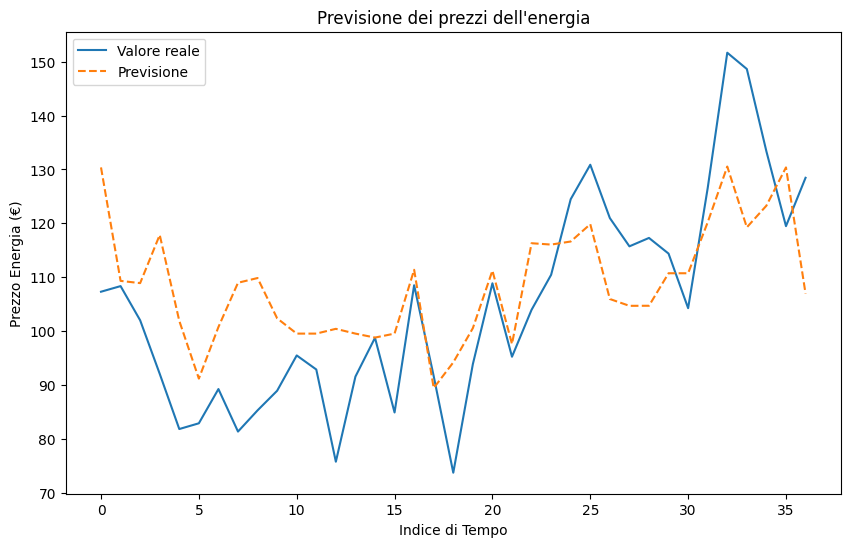

In [ ]:


# Calcoliamo e stampiamo l'errore quadratico medio (MSE) come metrica di valutazione
mse = mean_absolute_error(y_test.sort_index(), y_pred)
print(f'Mean absolute Error: {mse}')
mse = mean_absolute_error(y_test, np.average(y_test.values)*np.ones(len(y_test.values)))
print(f'Mean absolute Error of the average: {mse}')
# Visualizziamo i risultati
plt.figure(figsize=(10, 6))
plt.plot(y_test[""].sort_index().values, label='Valore reale')
#plt.plot(np.average(y_test.values)*np.ones(len(y_test.values)))
plt.plot(y_pred, label='Previsione', linestyle='dashed')
plt.legend()
plt.title("Previsione dei prezzi dell'energia")
plt.xlabel("Indice di Tempo")
plt.ylabel("Prezzo Energia (€)")
plt.show()


joblib.dump(model, 'previsione_prezzi_energia_model_GradientBoosterReg.pkl');

Mean absolute Error: 19.760750334459395
Mean absolute Error of the average: 15.802837229121014


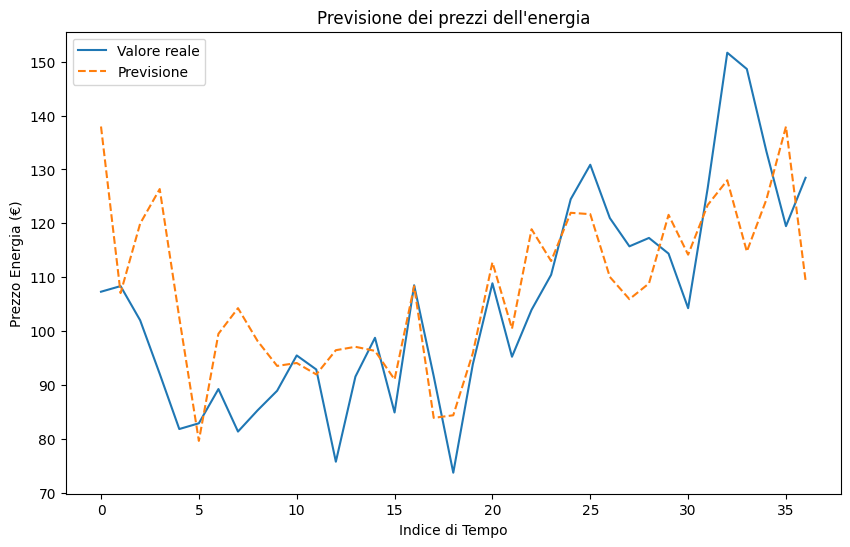

['previsione_prezzi_energia_model_Random_Forest.pkl']

In [ ]:
# Creazione del modello di regressione lineare
model = RandomForestRegressor(n_estimators=10000, random_state=42)

# Addestramento del modello
model.fit(X_train, y_train)

# Previsione sui dati di test
y_pred = model.predict(X_test.sort_index())



# Calcoliamo e stampiamo l'errore quadratico medio (MSE) come metrica di valutazione
mse = mean_absolute_error(y_test, y_pred)
print(f'Mean absolute Error: {mse}')
mse = mean_absolute_error(y_test, np.average(y_test.values)*np.ones(len(y_test.values)))
print(f'Mean absolute Error of the average: {mse}')
# Visualizziamo i risultati
plt.figure(figsize=(10, 6))
plt.plot(y_test.sort_index().values, label='Valore reale')
#plt.plot(np.average(y_test.values)*np.ones(len(y_test.values)))
plt.plot(y_pred, label='Previsione', linestyle='dashed')
plt.legend()
plt.title("Previsione dei prezzi dell'energia")
plt.xlabel("Indice di Tempo")
plt.ylabel("Prezzo Energia (€)")
plt.show()


joblib.dump(model, 'previsione_prezzi_energia_model_Random_Forest.pkl')

# Trial

In [ ]:
meteo_jan_25_df=pd.read_csv("Meteo Database csv\Milano-2025-Gennaio.csv", sep=";")
meteo_jan_25_df.rename(columns={"DATA": "Data"}, inplace=True)


#data column rename
meteo_jan_25_df.rename(columns={"DATA": "Data"}, inplace=True)

#data set to index
meteo_jan_25_df.set_index(pd.to_datetime(meteo_jan_25_df["Data"], dayfirst=True), inplace=True)

#Dropped data column
meteo_jan_25_df.drop(["Data"], inplace=True,  axis=1)

#week-day based score added
week_days=[0, 0, 0, 1, 1, 0, 0]
week_year=[]
j=0
for i in range(len(meteo_jan_25_df)):
    week_year.append(week_days[j])
    j=j+1
    if j==7:
        j=0

#day meteo phenomena conversion to score
stats=[]
for i in range(len(meteo_jan_25_df)):
    if meteo_jan_25_df["FENOMENI"].iloc[i] not in stats:
        stats.append(meteo_jan_25_df["FENOMENI"].iloc[i])

weather_keys={
    "nan":0,
    'nebbia ':1,
    'pioggia ':2,
    'pioggia nebbia ': 3,
    'pioggia temporale ':4,
    'pioggia temporale nebbia ':5, 
    'pioggia neve ':6
}

#NaN values set to sunny
meteo_jan_25_df["FENOMENI"]=meteo_jan_25_df["FENOMENI"].fillna(0)

for i in meteo_jan_25_df.index:
    if meteo_jan_25_df.loc[i, "FENOMENI"]!=0:
        meteo_jan_25_df.loc[i, "FENOMENI"]=weather_keys[meteo_jan_25_df.loc[i, "FENOMENI"]]

meteo_jan_25_df["Week day"]=week_year


In [ ]:
price_jan_25=pd.read_excel("PZ_Nord_Jan_2025.xlsx")
price_jan_25.rename(columns={"€/MWh": "Prezzo"}, inplace=True)
price_jan_25["Prezzo"] = price_jan_25.apply(
    lambda row: float(row["Prezzo"].replace(",",".")), axis=1
)
price_jan_25_average=np.zeros(len(price_jan_25)//24)

for i in range(len(price_jan_25_average)):
    value=np.average(price_jan_25["Prezzo"].iloc[i*24:(1+i)*24])
    price_jan_25_average[i]=value


In [ ]:
meteo_jan_25_df["price"]=price_jan_25_average
X = meteo_jan_25_df[['TMIN °C', 'TMAX °C', 'TMEDIA °C', 'UMIDITA %',
       'VISIBILITA km', 'PRESSIONESLM mb', 'PRESSIONEMEDIA mb', 'PIOGGIA mm', "Week day", "FENOMENI"]]

X=X.drop("1/1/2025")
#X["Prices_y"]=price_jan_25_average[0:-1]

model_trial=joblib.load("previsione_prezzi_energia_model_GradientBoosterReg.pkl")

display(X)
samples_df=X.sample(frac=1)
display(samples_df)
y=model_trial.predict(samples_df)

forecast=pd.DataFrame({
    'Price':y
})
forecast.index=samples_df.index
forecast.sort_index(inplace=True)
display(forecast)

,TMIN °C,TMAX °C,TMEDIA °C,UMIDITA %,VISIBILITA km,PRESSIONESLM mb,PRESSIONEMEDIA mb,PIOGGIA mm,Week day,FENOMENI
Data,,,,,,,,,,
2025-01-02,4,7,5,88,3,1021,0,0,0,2
2025-01-03,1,11,6,80,15,1014,0,0,0,0
2025-01-04,2,6,4,91,5,1021,0,0,1,3
2025-01-05,4,5,4,91,4,1018,0,0,1,2
2025-01-06,4,5,4,98,2,1013,0,0,0,2
2025-01-07,4,7,5,93,9,1009,0,0,0,2
2025-01-08,5,6,5,95,5,1013,0,0,0,3
2025-01-09,5,8,7,96,10,1010,0,0,0,2
2025-01-10,3,10,6,82,18,1013,0,0,0,1


,TMIN °C,TMAX °C,TMEDIA °C,UMIDITA %,VISIBILITA km,PRESSIONESLM mb,PRESSIONEMEDIA mb,PIOGGIA mm,Week day,FENOMENI
Data,,,,,,,,,,
2025-01-23,6,9,7,96,9,1013,0,0,0,3
2025-01-13,-4,6,1,73,20,1031,0,0,0,0
2025-01-16,-3,9,3,77,20,1033,0,0,0,0
2025-01-07,4,7,5,93,9,1009,0,0,0,2
2025-01-21,4,8,7,95,9,1018,0,0,0,3
2025-01-31,4,7,6,95,10,1024,0,0,0,3
2025-01-30,3,12,7,86,17,1020,0,0,0,0
2025-01-02,4,7,5,88,3,1021,0,0,0,2
2025-01-18,-3,8,3,82,20,1029,0,0,1,0


,Price
Data,
2025-01-02,123.951650
2025-01-03,120.873328
2025-01-04,122.331495
2025-01-05,122.331495
2025-01-06,130.377904
2025-01-07,108.894052
2025-01-08,130.538602
2025-01-09,124.537197
2025-01-10,127.911363


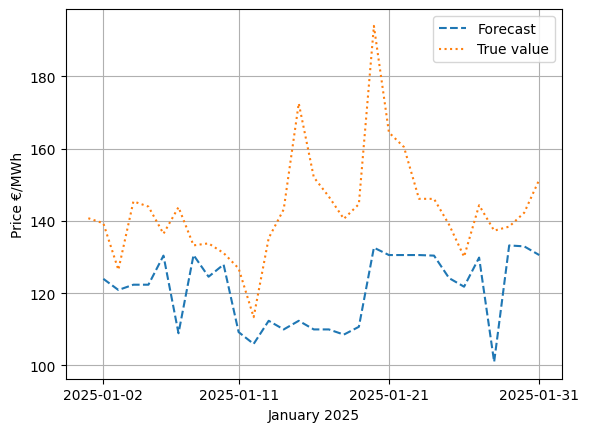

In [ ]:
plt.plot(forecast.index,forecast["Price"],  linestyle="--", label="Forecast")
plt.plot( meteo_jan_25_df.index,meteo_jan_25_df["price"], linestyle=":", label="True value");
plt.xticks([X.index[0], X.index[9], X.index[19], X.index[29]]);
plt.grid()
plt.xlabel("January 2025");
plt.ylabel(f"Price €/MWh");
plt.legend();

